In [1]:
import pandas as pd
import glob
import bitermplus as btm
import numpy as np
import tmplot as tmp
import time
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_theme(palette="pastel")

In [2]:
video_files = glob.glob("../../Data Collection/Labeled video files/*.csv") 
video_df = pd.concat((pd.read_csv(f, header = 0) for f in video_files))

In [3]:
# select only valid videos
video_df = video_df[video_df["valid"] == "valid"]
print(video_df.head())
print(video_df.shape)

    Unnamed: 0     video_id  \
1            1  vYzSzy6IwRI   
3            3  Ad8knG-9l2A   
5            5  SVyPVVXFpkU   
9            9  z67yc8r2WNw   
11          11  71SbVFBhaZk   

                                                title          published_at  \
1   E-AUTO mit 100% WASSERKRAFT laden | Prototyp n...  2021-04-01T08:00:27Z   
3   Breaking Elektro-News: Xiaomi plant Elektroaut...  2021-04-01T05:00:02Z   
5   Model 3 Facelift (SR & LR): Analyse der Tests ...  2021-04-01T16:15:55Z   
9   Probleme und Mängel an meinem Audi E-Tron, Upd...  2021-04-02T17:11:32Z   
11  STAT E-STICS #12 | KIA EV6 und alle Elektroaut...  2021-04-02T15:30:01Z   

                  channel_id  view_count  like_count  comment_count  job  id  \
1   UCaCaZ-vKtnMG2_FKmEePChQ      4217.0       493.0            193    0   0   
3   UCsNdsFTTBj5jcRJSWeJ8-Xg      7432.0       613.0            129    0   0   
5   UCasePAQ_q7tbUGybICCj4NQ      5530.0       342.0             88    0   0   
9   UCddkvrnYqGRfO

In [4]:
# Remove punctuation
video_df['title_processed'] = video_df['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
video_df['title_processed'] = video_df['title_processed'].map(lambda x: x.lower())

video_titles = video_df['title_processed'].str.strip().tolist()

# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
titles_X, titles_vocabulary, titles_vocab_dict = btm.get_words_freqs(video_titles)
titles_tf = np.array(titles_X.sum(axis=0)).ravel()

In [5]:
# Vectorizing documents
titles_docs_vec = btm.get_vectorized_docs(video_titles, titles_vocabulary)
titles_docs_lens = list(map(len, titles_docs_vec))

In [6]:
# Generating title biterms
title_biterms = btm.get_biterms(titles_docs_vec)

In [7]:
# Initializing and running titles model
def btm_model(topics, alpha, beta):
    titles_model = btm.BTM(
        titles_X, titles_vocabulary, seed=12321, T=topics, M=5, alpha=alpha, beta=beta)
    titles_model.fit(title_biterms, iterations=20)
    titles_p_zd = titles_model.transform(titles_docs_vec)
    
    return titles_model

def Average(l): 
    avg = sum(l) / len(l) 
    return avg

In [8]:
# Determening the number of topics by running the model with a fixed alpha = 0.01 and beta = 0.1
coherence_list = []
perplexity_list = []
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

for k in topics_range:
    # get the coherence score for the given parameters
    model = btm_model(k, 0.1, 0.1)
            
    perplexity = model.perplexity_
    coherence = model.coherence_
    
    coherence_list.append(Average(coherence))
    perplexity_list.append(perplexity)

100%|███████████████████████████████████████████████████████████████████████████| 3783/3783 [00:00<00:00, 27152.36it/s]


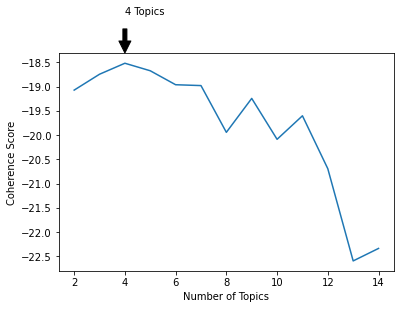

4 -18.52100110644131


In [9]:
ymax = max(coherence_list)
ymax_string = str(ymax)
xpos = coherence_list.index(ymax)
xmax = topics_range[xpos]
xmax_string = str(xmax)
plt.plot(topics_range, coherence_list)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.annotate(xmax_string + ' Topics' , xy=(xmax, ymax), xytext=(xmax, ymax+1),
            arrowprops=dict(facecolor='black', shrink=0.22),
            )
plt.show()

print(xmax, ymax)

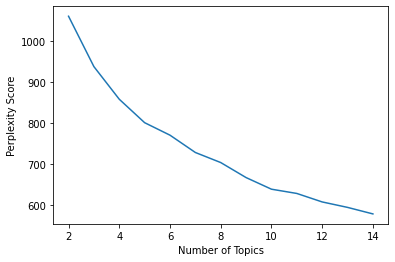

In [10]:
plt.plot(topics_range, perplexity_list)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [11]:
# Topic parameter 
k = 4
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))

model_results = {'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }


# iterate through alpha values
for a in alpha:
    # iterare through beta values
    for b in beta:
        # get the coherence score for the given parameters
        model = btm_model(k, a, b)
            
        perplexity = model.perplexity_
        coherence = model.coherence_
            
        # Save the model results
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(Average(coherence))
        model_results['Perplexity'].append(perplexity)

100%|███████████████████████████████████████████████████████████████████████████| 3783/3783 [00:00<00:00, 32059.90it/s]


In [12]:
benchmark_df = pd.DataFrame(model_results)
print(benchmark_df)

benchmark_df.to_csv("benchmark.csv", index=False)

    Alpha  Beta  Coherence  Perplexity
0    0.01  0.01 -18.718847  960.896713
1    0.01  0.31 -18.355997  827.588209
2    0.01  0.61 -19.522770  829.657676
3    0.01  0.91 -19.304843  839.430892
4    0.31  0.01 -18.718847  960.896717
5    0.31  0.31 -18.355997  827.588210
6    0.31  0.61 -19.522770  829.657668
7    0.31  0.91 -19.782582  839.507676
8    0.61  0.01 -18.718847  960.895425
9    0.61  0.31 -18.355997  827.588212
10   0.61  0.61 -19.522770  829.657659
11   0.61  0.91 -19.304843  839.491210
12   0.91  0.01 -18.718847  960.895429
13   0.91  0.31 -18.355997  827.587503
14   0.91  0.61 -19.522770  829.657651
15   0.91  0.91 -19.304843  839.661980


In [13]:
titles_model = btm.BTM(
titles_X, titles_vocabulary, seed=12321, T=4, M=5, alpha=0.01, beta=0.31)
titles_model.fit(title_biterms, iterations=20)
titles_p_zd = titles_model.transform(titles_docs_vec)

100%|███████████████████████████████████████████████████████████████████████████| 3783/3783 [00:00<00:00, 37454.36it/s]


In [14]:
p_zd = titles_model.transform(titles_docs_vec)

100%|███████████████████████████████████████████████████████████████████████████| 3783/3783 [00:00<00:00, 32349.32it/s]


In [15]:
words_topics_df = titles_model.df_words_topics_

words_topics_0 = pd.DataFrame(words_topics_df[0])
words_topics_0["word"] = words_topics_df.index

words_topics_1 = pd.DataFrame(words_topics_df[1])
words_topics_1["word"] = words_topics_df.index

words_topics_2 = pd.DataFrame(words_topics_df[2])
words_topics_2["word"] = words_topics_df.index

words_topics_3 = pd.DataFrame(words_topics_df[3])
words_topics_3["word"] = words_topics_df.index



                    0         word
test         0.032154         test
review       0.023964       review
der          0.022223          der
im           0.021666           im
mit          0.018144          mit
fahrbericht  0.016838  fahrbericht
vw           0.015977           vw
reichweite   0.014661   reichweite
2021         0.014530         2021
und          0.014297          und


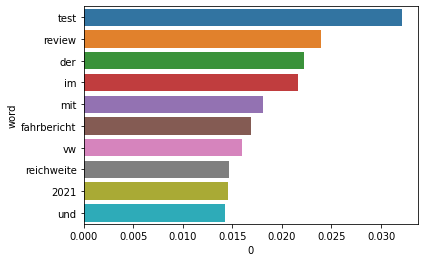

In [16]:
top_0 = words_topics_0.nlargest(10, 0)

print(top_0)
ax = sns.barplot(x=0, y="word", data=top_0)

              1   word
tesla  0.041765  tesla
model  0.030048  model
und    0.024381    und
die    0.023267    die
der    0.020586    der
das    0.016074    das
auto   0.014163   auto
ist    0.011231    ist
was    0.010673    was
mit    0.010594    mit


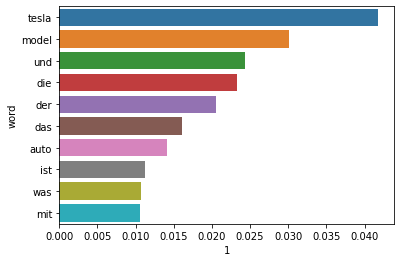

In [17]:
top_1 = words_topics_1.nlargest(10, 1)

print(top_1)
ax = sns.barplot(x=1, y="word", data=top_1)

                    2         word
für          0.022796          für
tesla        0.018800        tesla
elektroauto  0.017351  elektroauto
mit          0.017321          mit
der          0.014555          der
in           0.013955           in
und          0.013428          und
laden        0.012813        laden
die          0.012623          die
wallbox      0.011071      wallbox


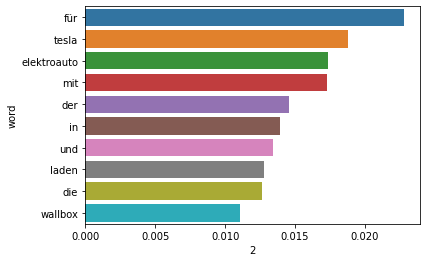

In [18]:
top_2 = words_topics_2.nlargest(10, 2)
print(top_2)
ax = sns.barplot(x=2, y="word", data=top_2)

                    3         word
elektroauto  0.028685  elektroauto
mit          0.028224          mit
tesla        0.025597        tesla
im           0.023309           im
der          0.021675          der
model        0.020585        model
und          0.015755          und
id3          0.015730          id3
vw           0.015537           vw
wie          0.014931          wie


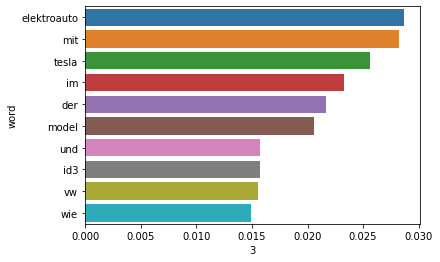

In [19]:
top_3 = words_topics_3.nlargest(10, 3)
print(top_3)
ax = sns.barplot(x=3, y="word", data=top_3)

In [20]:
top_words = btm.get_top_topic_words(
    titles_model,
    words_num=100)


top_words_df = pd.DataFrame(top_words)
print(top_words_df.head())

top_docs = btm.get_top_topic_docs(
    video_df['title_processed'],
    p_zd,
    docs_num=3783,
    topics_idx=[0,1,2,3])

top_docs_df = pd.DataFrame(top_docs)
print(top_docs_df.head())

top_words_df.to_csv("top_words.csv", index=False)

   topic0 topic1       topic2       topic3
0    test  tesla          für  elektroauto
1  review  model        tesla          mit
2     der    und  elektroauto        tesla
3      im    die          mit           im
4     mit    der          der          der
                                              topic0  \
0  nissan ariya | weltpremiere: vollelektrischer ...   
1  ⚡️⚡️⚡️ 2020 ds 3 crossback e-tense kaufberatun...   
2  ⚡️⚡️⚡️ 2021 kia ev6 awd gt line - kaufberatung...   
3  2022 mazda2 e-skyactiv-g 115 m hybrid sports-l...   
4                         renault captur e-tech phev   

                                              topic1  \
0                      umweltsünder e auto doku arte   
1  android auto wireless nachrüsten | android aut...   
2  anwalt klärt auf: wächtermodus / dashcam erlau...   
3  dieses tesla zubehör brauchst du | tips tricks...   
4      hoffe ihr gefällt mein e-auto 🥰  | daniel abt   

                                              topic2  \
0           

In [34]:
video_topics = btm.get_docs_top_topic(video_titles, titles_model.matrix_docs_topics_)

print(video_topics.head())



                                           documents  label
0  e-auto mit 100% wasserkraft laden | prototyp n...      2
1  breaking elektro-news: xiaomi plant elektroaut...      2
2  model 3 facelift (sr & lr): analyse der tests ...      1
3  probleme und mängel an meinem audi e-tron upda...      3
4  stat e-stics #12 | kia ev6 und alle elektroaut...      0


In [42]:
merged_video = pd.merge(video_topics,video_df,left_on='documents',right_on='title_processed')
merged_video = merged_video.drop(['documents', 'Unnamed: 0'], axis=1)
merged_video = merged_video.rename(columns={"label": "topic"})


print(merged_video.head())

merged_video.to_csv("video_topics.csv", index = False)


   topic     video_id                                              title  \
0      2  vYzSzy6IwRI  E-AUTO mit 100% WASSERKRAFT laden | Prototyp n...   
1      2  Ad8knG-9l2A  Breaking Elektro-News: Xiaomi plant Elektroaut...   
2      1  SVyPVVXFpkU  Model 3 Facelift (SR & LR): Analyse der Tests ...   
3      3  z67yc8r2WNw  Probleme und Mängel an meinem Audi E-Tron, Upd...   
4      0  71SbVFBhaZk  STAT E-STICS #12 | KIA EV6 und alle Elektroaut...   

           published_at                channel_id  view_count  like_count  \
0  2021-04-01T08:00:27Z  UCaCaZ-vKtnMG2_FKmEePChQ      4217.0       493.0   
1  2021-04-01T05:00:02Z  UCsNdsFTTBj5jcRJSWeJ8-Xg      7432.0       613.0   
2  2021-04-01T16:15:55Z  UCasePAQ_q7tbUGybICCj4NQ      5530.0       342.0   
3  2021-04-02T17:11:32Z  UCddkvrnYqGRfODPMUQqisiw      6389.0       291.0   
4  2021-04-02T15:30:01Z  UCDDj2GWklzZ09X7R9OtsX3Q     38400.0       508.0   

   comment_count  job  id  valid  \
0            193    0   0  valid   
1       